In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/working/recent_model.keras
/kaggle/working/recent_model.h5


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
                             

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


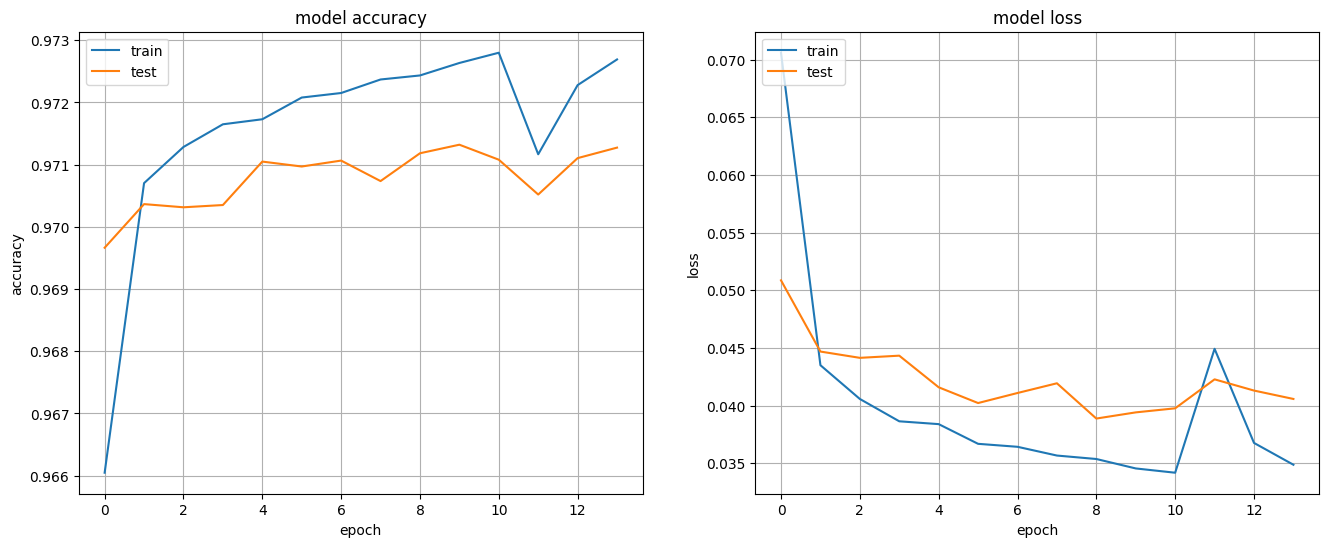

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import  Conv2D, UpSampling2D, concatenate, MaxPooling2D, Dropout, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping

repertoire_images = "/kaggle/input/lung-radio/data_img/images/"
repertoire_masques = "/kaggle/input/lung-radio/data_mask/mask/"

noms_images = os.listdir(repertoire_images)
noms_masques = os.listdir(repertoire_masques)

assert set(noms_images) == set(noms_masques)

chemins_images = [os.path.join(repertoire_images, nom) for nom in noms_images]
chemins_masques = [os.path.join(repertoire_masques, nom) for nom in noms_masques]

dataset = tf.data.Dataset.from_tensor_slices((chemins_images, chemins_masques))

def charger_et_pretraiter(image_path, masque_path):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize_with_pad(image, target_height=256, target_width=256)  # Redimensionnez avec le rembourrage si nécessaire
    image = tf.cast(image, tf.float32) / 255.0

    masque = tf.io.read_file(masque_path)
    masque = tf.image.decode_image(masque, channels=1)
    masque = tf.image.resize_with_pad(masque, target_height=256, target_width=256)  # Redimensionnez avec le rembourrage si nécessaire
    masque = tf.cast(masque, tf.float32) / 255.0

    return image, masque


dataset = dataset.map(charger_et_pretraiter)

def normaliser_images_masques(image, masque):
    
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, masque


dataset = dataset.map(normaliser_images_masques)
dataset = dataset.batch(8)
dataset_size = dataset.cardinality().numpy()


validation_fraction = 0.2
validation_size = int(validation_fraction * dataset_size)


dataset_validation = dataset.take(validation_size)


dataset_train = dataset.skip(validation_size)

def unet_model_with_pretrained_encoder(input_shape=(256, 256, 3), base_model=None):

    if base_model is None:
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)


    for layer in base_model.layers:
        layer.trainable = False


    encoder_output = base_model.get_layer('block4_conv4').output  # Modifier cette ligne


    
    pool4 = MaxPooling2D((2,2), padding='same')(encoder_output)
    
    conv5 = Conv2D(16, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(16, 3, activation='relu', padding='same')(conv5)
    conv5 = Conv2D(16, 3, activation='relu', padding='same')(conv5)
    conv5 = Conv2D(16, 3, activation='relu', padding='same')(conv5)
    pool5 = MaxPooling2D((2,2), padding='same')(conv5)
    
    conv6 = Conv2D(32, 3, activation='relu', padding='same')(pool5)
    conv6 = Conv2D(32, 3, activation='relu', padding='same')(conv6)
    conv6 = Conv2D(32, 3, activation='relu', padding='same')(conv6)
    conv6 = Conv2D(32, 3, activation='relu', padding='same')(conv6)
    

    up7 = concatenate([Conv2DTranspose(16, 3, strides=(2,2), padding='same')(conv6), conv5], axis=-1)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(512, 3, strides=(2,2), padding='same')(conv7), base_model.get_layer('block4_conv3').output], axis=-1)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(256, 3, strides=(2,2), padding='same')(conv8), base_model.get_layer('block3_conv4').output], axis=-1)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    up10 = concatenate([Conv2DTranspose(128, 3, strides=(2,2), padding='same')(conv9), base_model.get_layer('block2_conv2').output], axis=-1)
    conv10 = Conv2D(128, 3, activation='relu', padding='same')(up10)
    conv10 = Conv2D(128, 3, activation='relu', padding='same')(conv10)
    
    up11 = concatenate([Conv2DTranspose(256, 3, strides=(2,2), padding='same')(conv10), base_model.get_layer('block1_conv2').output], axis=-1)
    conv11 = Conv2D(256, 3, activation='relu', padding='same')(up11)
    conv11 = Conv2D(256, 3, activation='relu', padding='same')(conv11)
    

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv11)


    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

    return model


model_with_pretrained_encoder = unet_model_with_pretrained_encoder()


model_with_pretrained_encoder.summary()

model_with_pretrained_encoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model_with_pretrained_encoder.fit(dataset_train,
                                            validation_data=dataset_validation,
                                            epochs=50,
                                            callbacks=[early_stopping])
model_with_pretrained_encoder.save("model.h5")

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'test'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
model_with_pretrained_encoder.save("m.h5")


1/1 [==============================] - 3s 3s/step
(256, 256, 1)


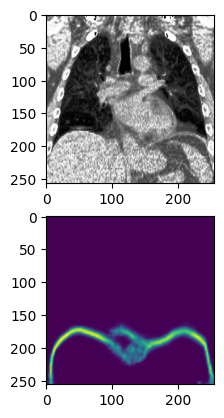

In [2]:
from PIL import Image, ImageOps
import numpy as np

img_test = Image.open("/kaggle/input/lung-test/ID_000133.png")
img_test = ImageOps.equalize(img_test)
img = img_test.convert("RGB").resize([256,256])
img = np.array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0
result = model_with_pretrained_encoder.predict(img)
print(result[0].shape)
import matplotlib.pyplot as plt

plt.subplot(2,1,1)
plt.imshow(img[0])
plt.subplot(2,1,2)
plt.imshow(result[0])
